## Imports

In [18]:

import pandas as pd
import numpy as np
import missingno as msno
import datetime
import matplotlib.pyplot as plt
import httpx
import json
import math
import os

from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go

from sklearn import tree
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from k_means_constrained import KMeansConstrained

import pmdarima as pm

## Helper functions

In [19]:
def get_folder_dict(path):
    # get the subfolder directories (year-month)
    dir_list = os.listdir(path)
    dir_list.sort()

    if '.DS_Store' in dir_list:
        dir_list.remove('.DS_Store')

    # create dictionary with files per subfolder
    dir_dict = dict()

    for folder in dir_list:
        dir_dict[folder] = os.listdir(path + '/' + folder)
        
    return dir_dict

In [20]:
def compiler_by_force(path, force, target_path):
    ''' Exports three csv files with the compiled data for the selected force'''
    # create dictionary with files per subfolder
    dir_dict = get_folder_dict(path)
    
    # create three list of paths for the street, outcomes and stop and search data of the selected force
    force_street_paths = []
    force_outcomes_paths = []
    force_stop_and_search_paths = []
    anomalies_paths = []

    for key in dir_dict:
        for item in dir_dict[key]:
            if force in item:
                if 'street' in item:
                    force_street_paths.append(key + '/' + item)
                elif 'outcomes' in item:
                    force_outcomes_paths.append(key + '/' + item)
                elif 'stop-and-search' in item:
                    force_stop_and_search_paths.append(key + '/' + item)
                else:
                    anomalies_paths.append(key + '/' + item)
    
    # create three dataframes for the street, outcomes and stop and search data of the selected force
    df_force_street = pd.DataFrame()
    df_force_outcomes = pd.DataFrame()
    df_force_stop_and_search = pd.DataFrame()

    for path_extension in force_street_paths:
        df = pd.read_csv(path + '/' + path_extension)
        df_force_street = pd.concat([df_force_street, df])
    print('Compiled ' + str(len(force_street_paths)) + ' number of street files')

    for path_extension in force_outcomes_paths:
        df = pd.read_csv(path + '/' + path_extension)
        df_force_outcomes = pd.concat([df_force_outcomes, df])
    print('Compiled ' + str(len(force_outcomes_paths)) + ' number of outcomes files')

    for path_extension in force_stop_and_search_paths:
        df = pd.read_csv(path + '/' + path_extension)
        df_force_stop_and_search = pd.concat([df_force_stop_and_search, df])
    print('Compiled ' + str(len(force_stop_and_search_paths)) + ' number of stop and search files')
    
    # export the three dataframes to csv    
    df_force_street.to_csv(target_path + '/' + force + '_street.csv')
    df_force_outcomes.to_csv(target_path + '/' + force + '_outcomes.csv')
    df_force_stop_and_search.to_csv(target_path + '/' + force + '_stop_and_search.csv')

In [21]:
def get_all_force_names(path):
    # create dictionary with files per subfolder
    dir_dict = get_folder_dict(path)
    force_list = []
    for key in dir_dict:
        for item in dir_dict[key]:
            if 'stop-and-search' in item:
                force = '-'.join(item.split('.')[0][8:].split('-')[:-3])
            else:
                force = '-'.join(item.split('.')[0][8:].split('-')[:-1])
            if force not in force_list:
                force_list.append(force)
    return force_list
    

In [22]:
def compile_all_forces(path, target_path):
    force_list = get_all_force_names(path)
    for force in force_list:
        compiler_by_force(path, force, target_path)
        print('Compiled data for ' + force)

In [23]:
def load_forces(forces):
    df_streets = dict()
    df_outcomes = dict()
    df_stop_and_search = dict()
    
    for force in forces:
        file_path_streets = './Data/force_data/' + force + '_street.csv'
        file_path_outcomes = './Data/force_data/' + force + '_outcomes.csv'
        file_path_stop_and_search = './Data/force_data/' + force + '_stop_and_search.csv'
        
        df_streets[force] = pd.read_csv(file_path_streets, low_memory=False)
        df_outcomes[force] = pd.read_csv(file_path_outcomes, low_memory=False)
        df_stop_and_search[force] = pd.read_csv(file_path_stop_and_search, low_memory=False)
        
        df_stop_and_search[force]['Datetime'] = pd.to_datetime(df_stop_and_search[force]['Date'])
        df_stop_and_search[force]['Date'] = df_stop_and_search[force]['Datetime'].dt.date
    
    return df_streets, df_outcomes, df_stop_and_search

In [24]:
def plot_forces_sas(df, forces = []):
    df_dates = dict()
    plt.figure(figsize=(16, 8), dpi=150)
    
    if forces == []:
        for key in df:
            df_dates[key] = df[key]['Date'].value_counts()
            df_dates[key].sort_index(inplace=True)
            df_dates[key].plot(label=key)
    else:
        for force in forces:
            df_dates[force] = df[force]['Date'].value_counts()
            df_dates[force].sort_index(inplace=True)
            df_dates[force].plot(label=force)

    plt.ylabel('Number of stop and searches')
    plt.xlabel('Time')
    plt.legend()

In [25]:
def combine_csvs_in_dir_to_df(dir_name):
    df = pd.DataFrame()
    for root, directories, files in os.walk(dir_name):
        for file in tqdm(files):
            df = df.append(pd.read_csv(f'{dir_name}/{file}'))
    return df

In [32]:
def plot_forces_streets(df, forces=[]):
    df_months = dict()
    plt.figure(figsize=(16, 8), dpi=150)
    
    if forces == []:
        for key in df:
            df_months[key] = df[key]['Month'].value_counts()
            df_months[key].sort_index(inplace=True)
            df_months[key].plot(label=key)
    else:
        for force in forces:
            df_months[force] = df[force]['Month'].value_counts()
            df_months[force].sort_index(inplace=True)
            df_months[force].plot(label=force)

    plt.ylabel('Number of incidents')
    plt.xlabel('Months')
    plt.legend()

## Main

### Compiler

In [26]:
path = './Data/Jan_2010_Oct_2021'
target_path = './Data/force_data'
force = 'city-of-london'
compiler_by_force(path, force, target_path)

Compiled 131 number of street files
Compiled 118 number of outcomes files
Compiled 78 number of stop and search files


In [ ]:
path = './Data/Jan_2010_Oct_2021'
target_path = './Data/force_data'
compile_all_forces(path, target_path)

### EDA

In [28]:
forces = ['city-of-london', 'metropolitan', 'surrey', 'hertfordshire',
          'thames-valley', 'essex', 'kent', 'hampshire', 'bedfordshire']
df_streets, df_outcomes, df_stop_and_search = load_forces(forces)

In [29]:
df_streets['city-of-london'].head()

,Unnamed: 0,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,0,NaN,2010-12,City of London Police,City of London Police,-0.112952,51.518267,On or near Southampton Buildings,E01000914,Camden 028B,Vehicle crime,NaN,NaN
1,1,NaN,2010-12,City of London Police,City of London Police,-0.114940,51.518632,On or near Brownlow Street,E01000914,Camden 028B,Other crime,NaN,NaN
2,2,NaN,2010-12,City of London Police,City of London Police,-0.112952,51.518267,On or near Southampton Buildings,E01000914,Camden 028B,Other crime,NaN,NaN
3,3,NaN,2010-12,City of London Police,City of London Police,-0.112952,51.518267,On or near Southampton Buildings,E01000914,Camden 028B,Other crime,NaN,NaN
4,4,NaN,2010-12,City of London Police,City of London Police,-0.125742,51.516368,On or near Grape Street,E01000919,Camden 028D,Anti-social behaviour,NaN,NaN


In [30]:
df_streets['metropolitan'].shape, df_outcomes['metropolitan'].shape, df_stop_and_search['metropolitan'].shape

((11625548, 13), (5820841, 11), (1310977, 17))

<AxesSubplot:>

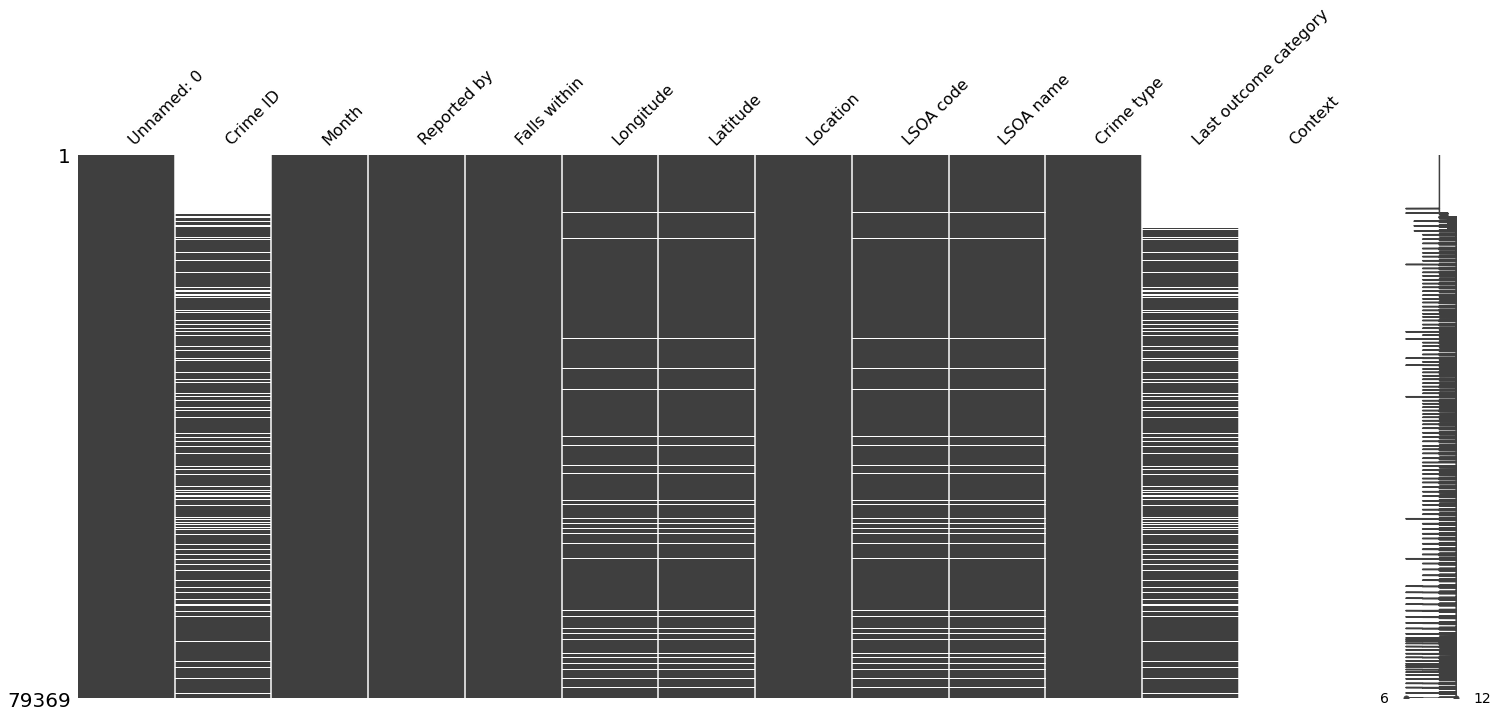

In [31]:
msno.matrix(df_streets['city-of-london'])

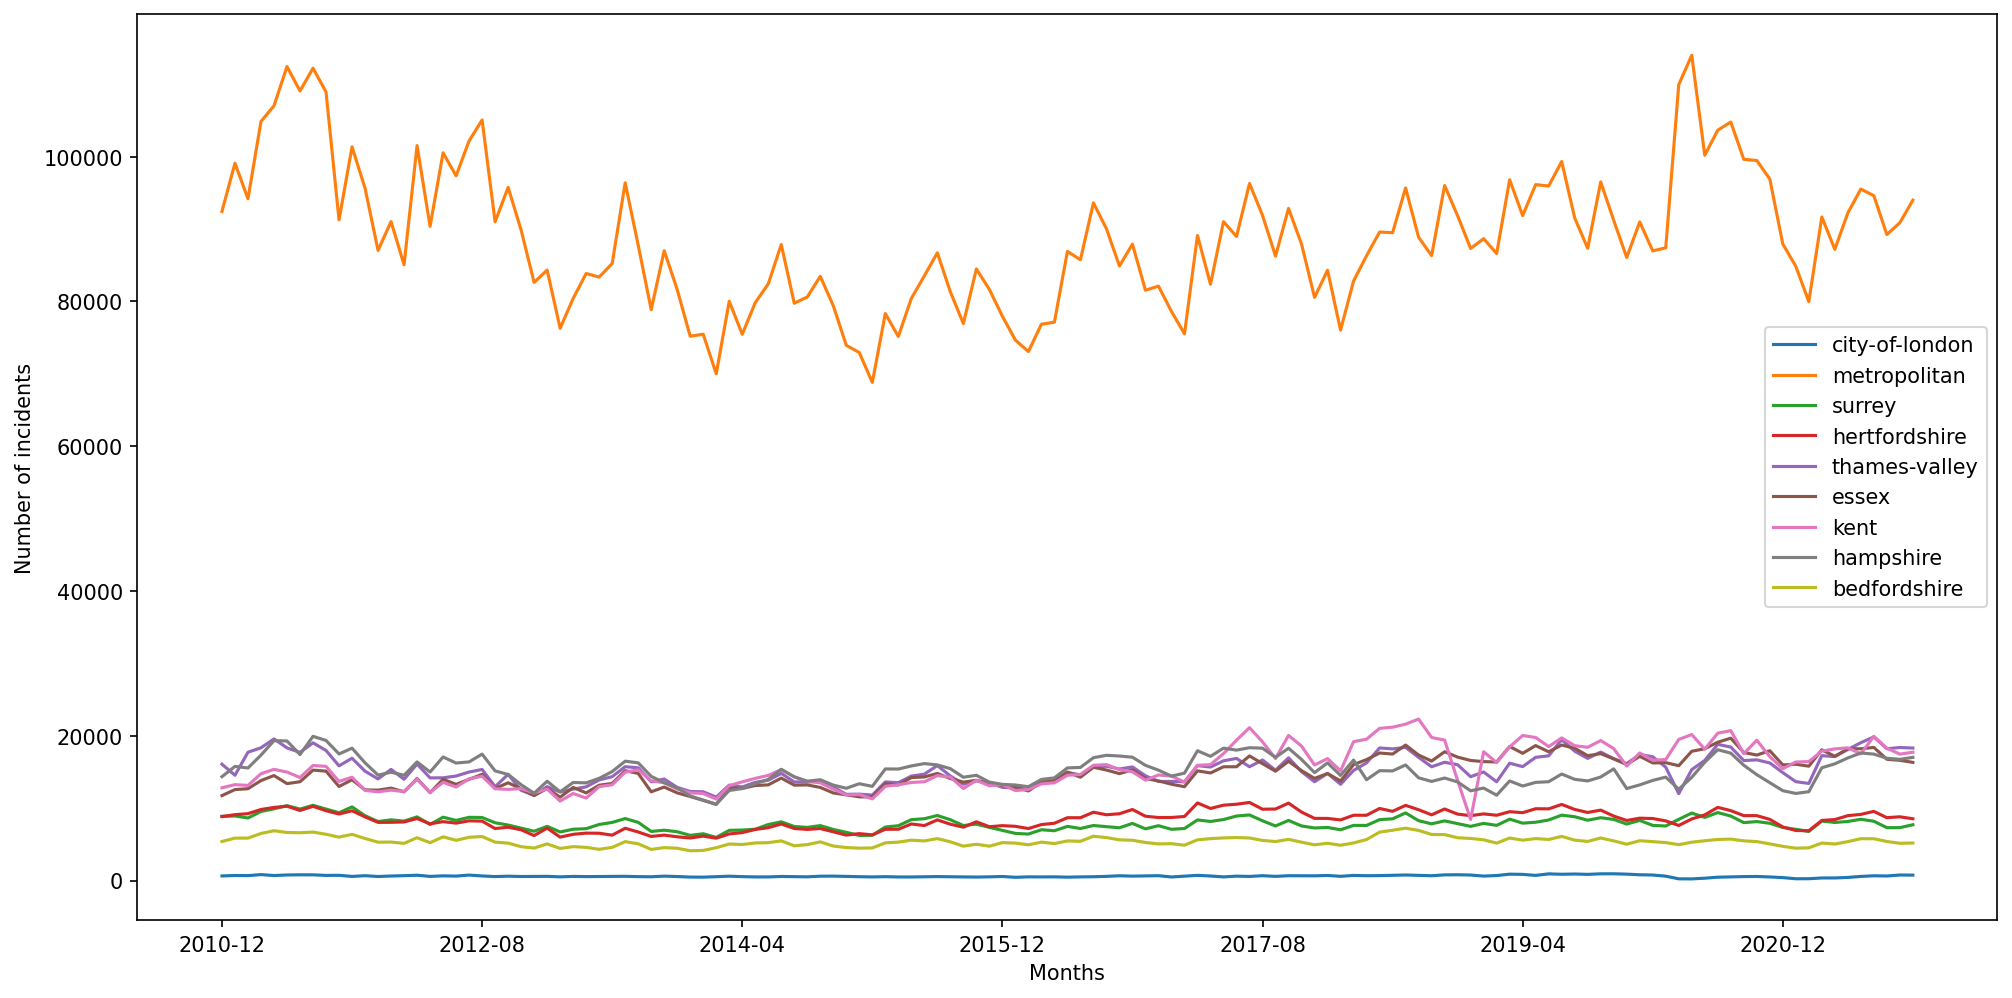

In [33]:
plot_forces_streets(df_streets)

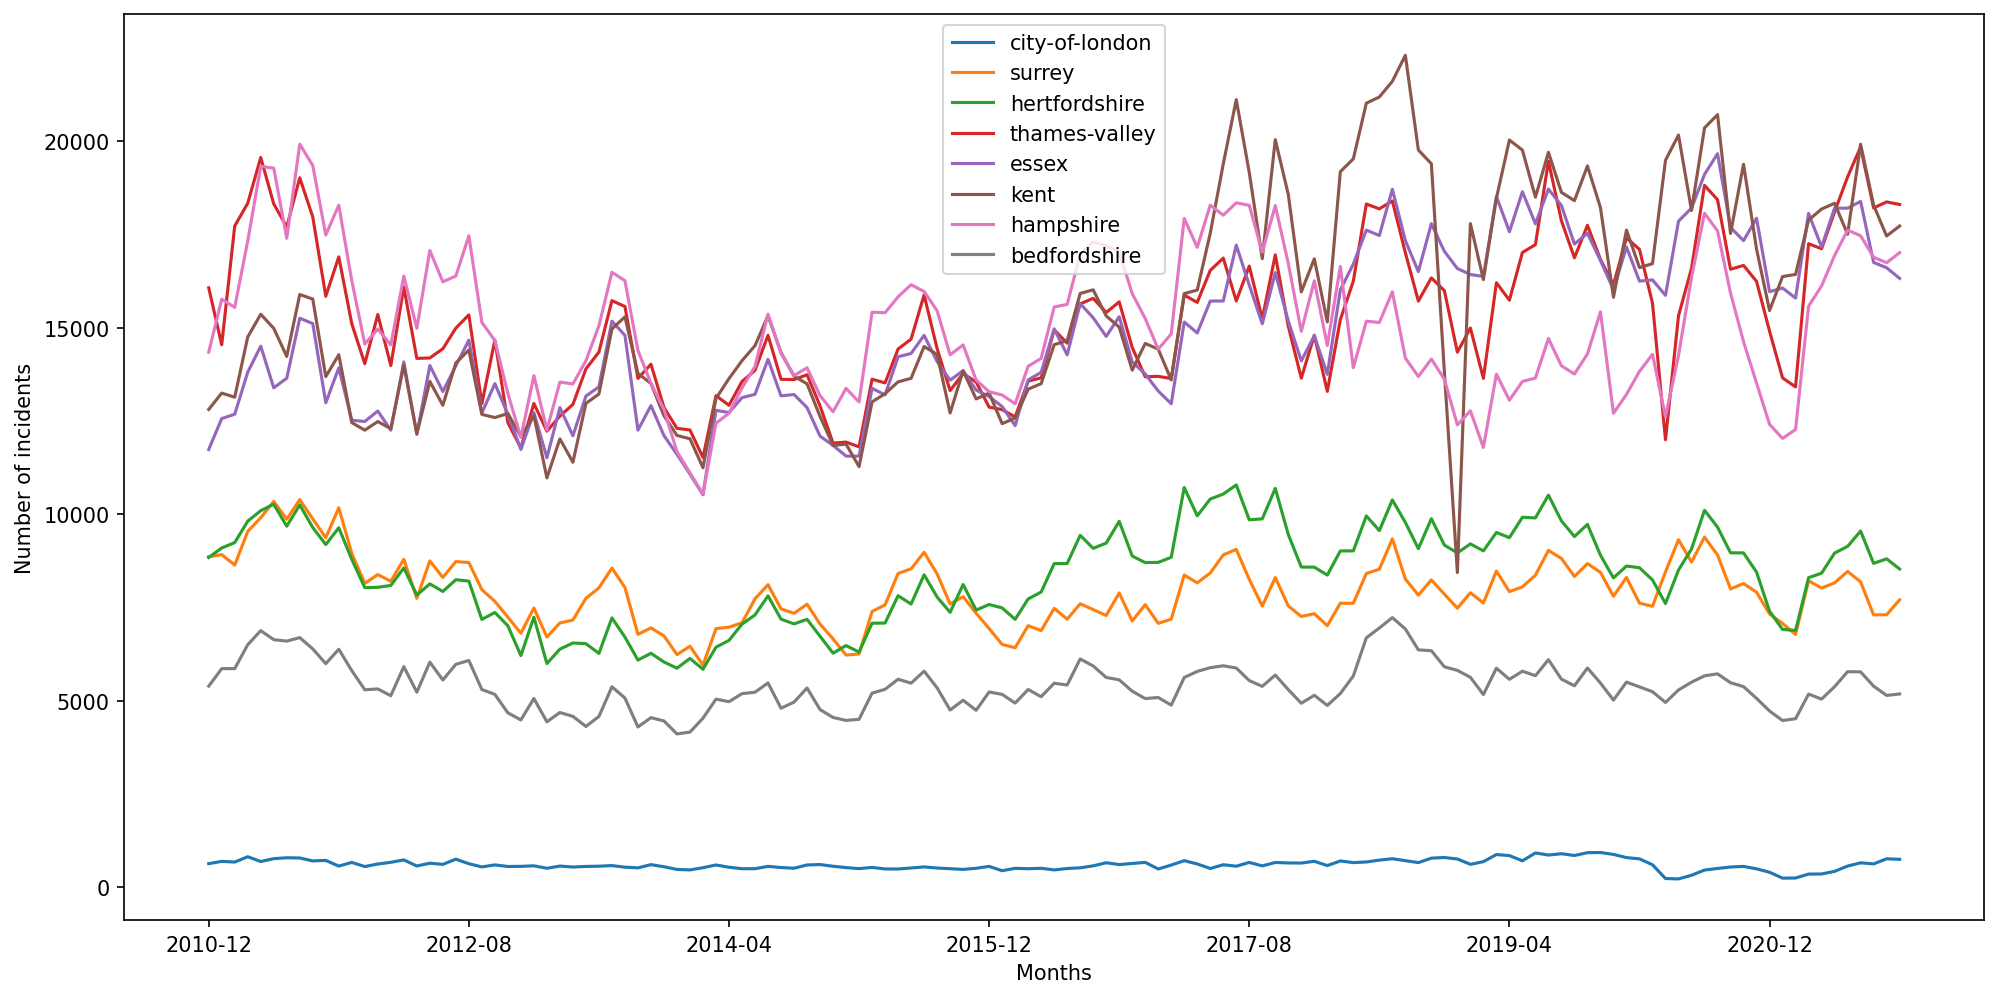

In [34]:
forces = ['city-of-london', 'surrey', 'hertfordshire',
          'thames-valley', 'essex', 'kent', 'hampshire', 'bedfordshire']
plot_forces_streets(df_streets, forces)

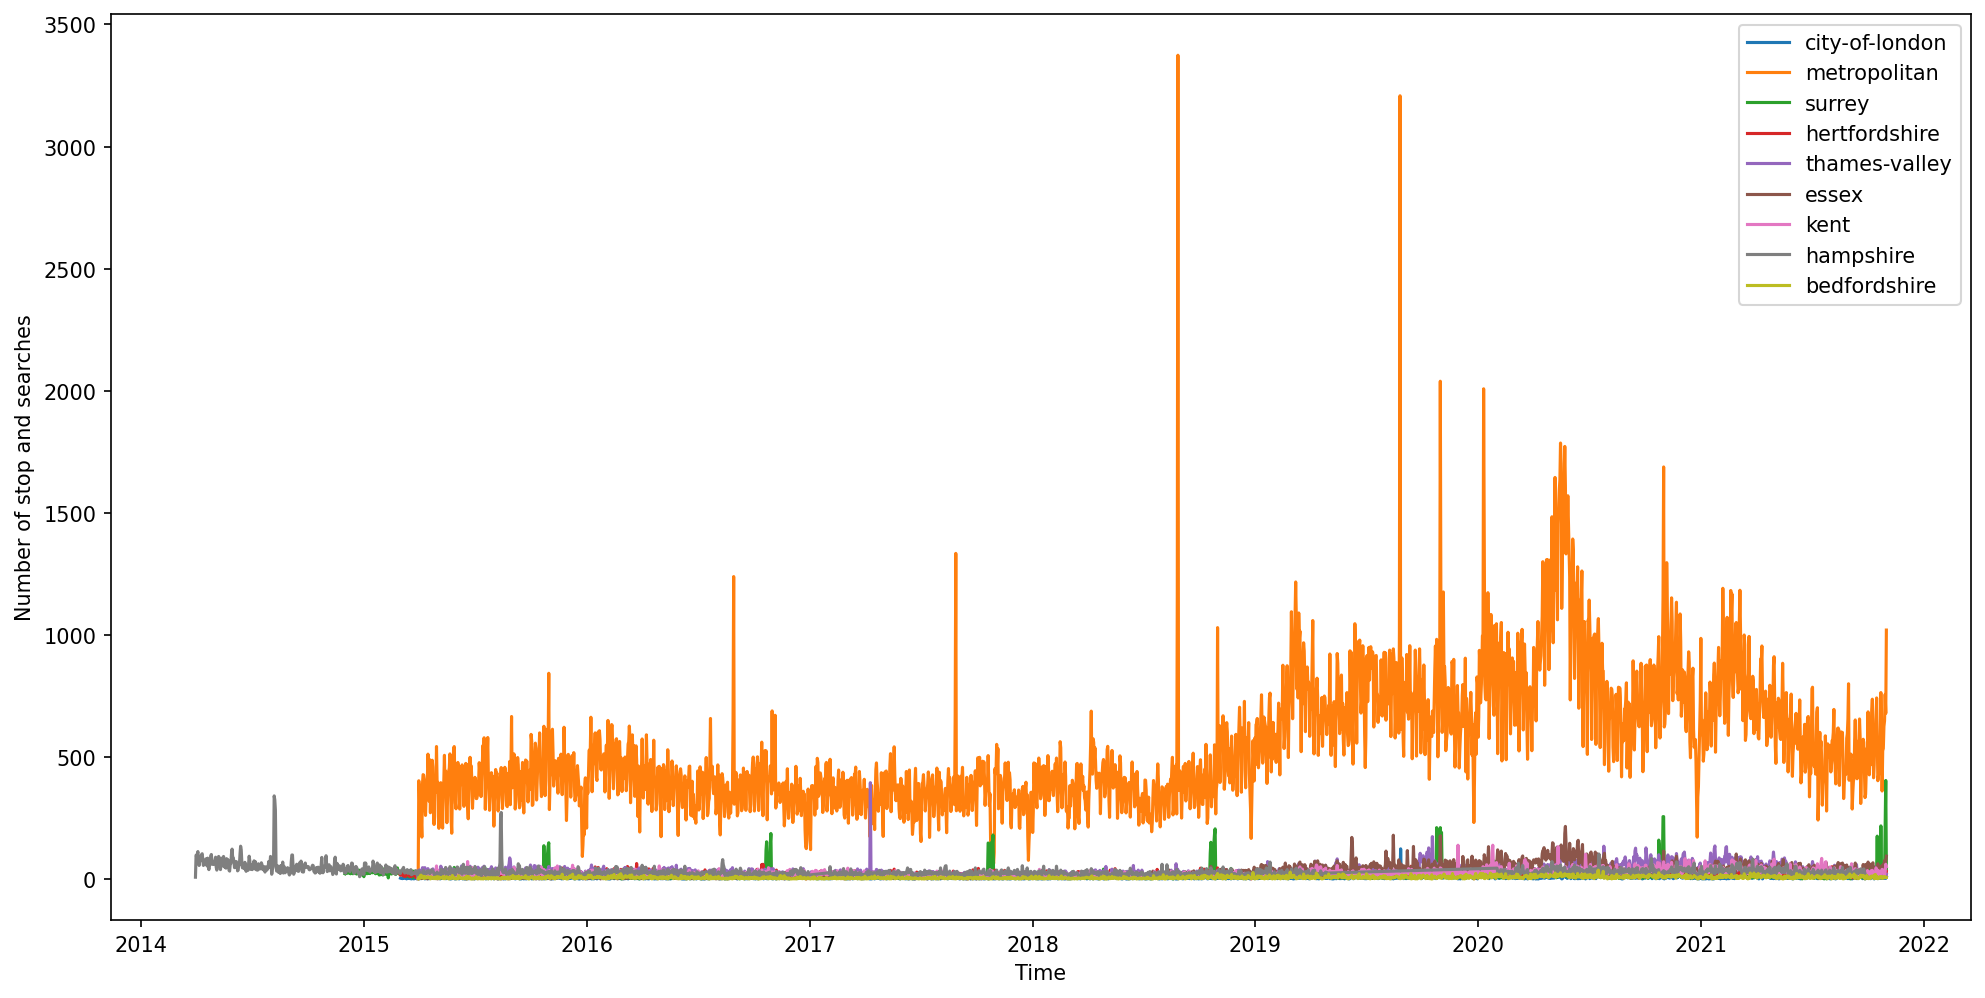

In [35]:
plot_forces_sas(df_stop_and_search)

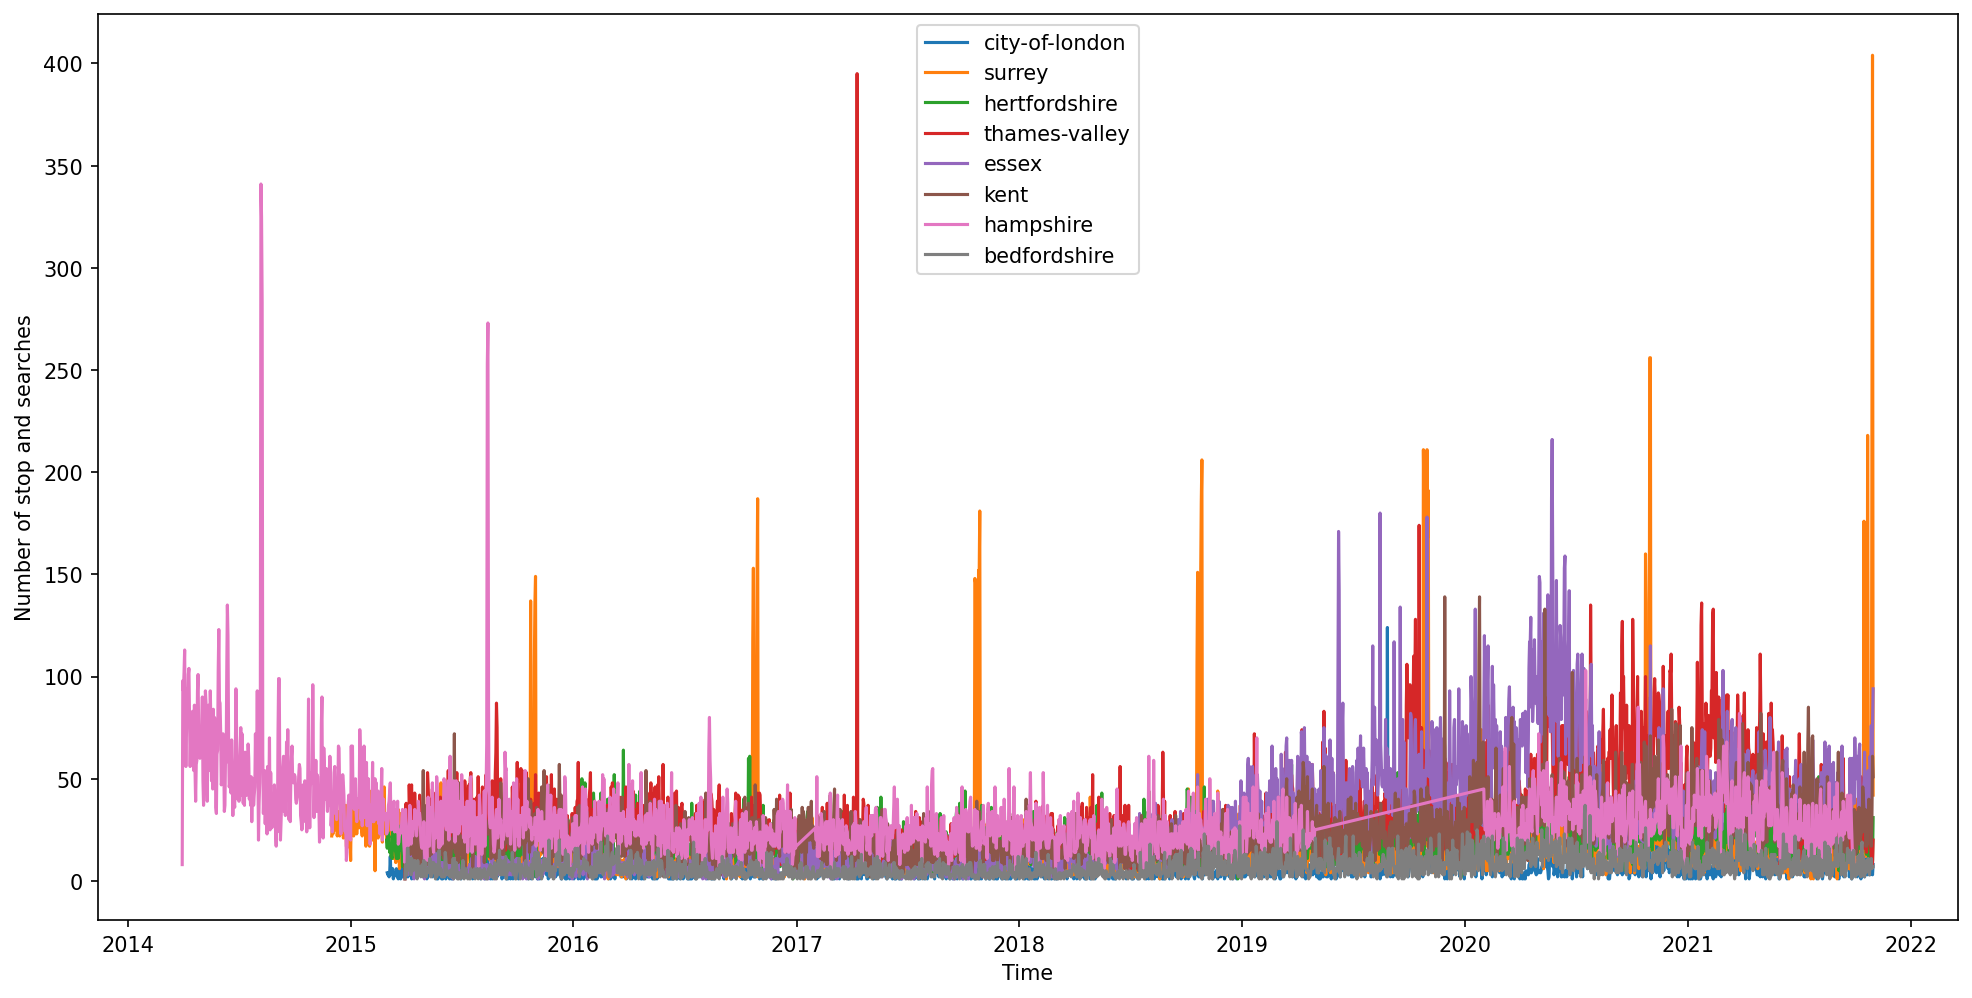

In [36]:
forces = ['city-of-london', 'surrey', 'hertfordshire',
          'thames-valley', 'essex', 'kent', 'hampshire', 'bedfordshire']
plot_forces_sas(df_stop_and_search, forces)

In [37]:
import pandas as pd
import numpy as np
path = 'https://raw.githubusercontent.com/selva86/datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [38]:
def df_to_ts(df):
    ts = pd.DataFrame()

    ts = df['Month'].value_counts()
    ts.sort_index(inplace=True)

    return ts

In [39]:
ts = df_to_ts(df_streets['city-of-london'])
ts

2010-12    635
2011-01    696
2011-02    678
2011-03    820
2011-04    692
          ... 
2021-06    570
2021-07    657
2021-08    628
2021-09    765
2021-10    750
Name: Month, Length: 131, dtype: int64

In [40]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [41]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [45]:
def adf_test(ts):    
    statistic, p_value, n_lags, nobs, critical_values, icbest  = adfuller(ts)
    # Format Output
    print(f'ADF Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary')

In [43]:
kpss_test(ts)

KPSS Statistic: 0.09311984500642378
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/MoshaLangerak_1/opt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/Users/MoshaLangerak_1/opt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [46]:
adf_test(ts)

ADF Statistic: -3.4951221261411805
p-value: 0.008113255478478881
Critial Values:
   1% : -3.4816817173418295
   5% : -2.8840418343195267
   10% : -2.578770059171598
Result: The series is stationary


In [50]:
outcomes = pd.read_csv("./Data/city-of-london/city-of-london_outcomes.csv") 
sas = pd.read_csv("./Data/city-of-london/city-of-london_stop_and_search.csv")
street = pd.read_csv("./Data/city-of-london/city-of-london_street.csv")

<AxesSubplot:xlabel='Month'>

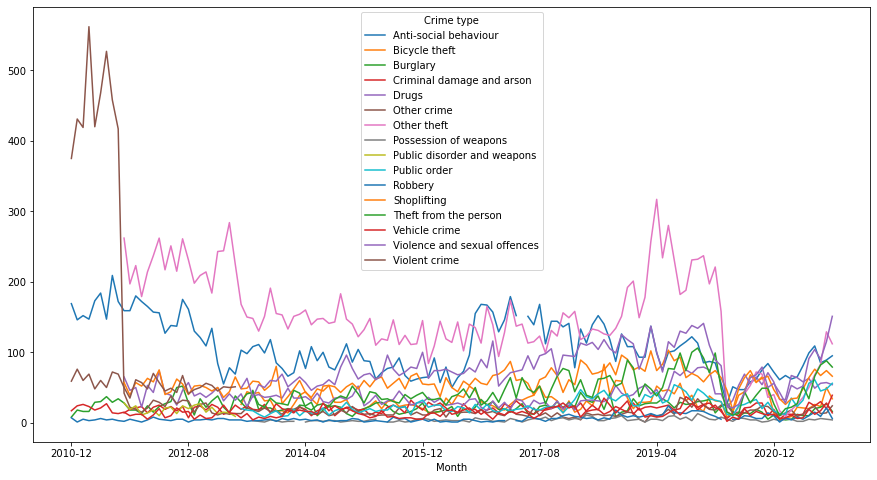

In [51]:
street.groupby(['Month', 'Crime type'])['Crime type'].count().unstack().plot(figsize = (15,8))  

<AxesSubplot:xlabel='Month'>

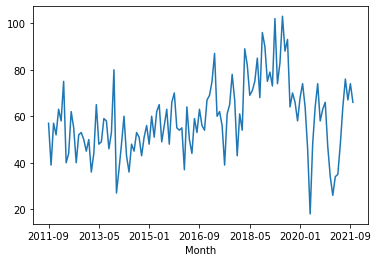

In [52]:
shop = street[street["Crime type"] == "Shoplifting"]
shop.groupby(['Month'])['Crime type'].count().plot()

<AxesSubplot:xlabel='Month'>

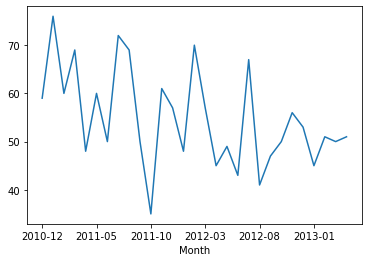

In [53]:
vio = street[street["Crime type"] == "Violent crime"]
vio.groupby(['Month'])['Crime type'].count().plot()

<AxesSubplot:xlabel='Month'>

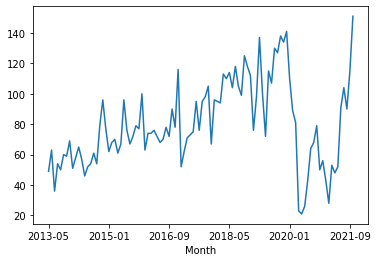

In [54]:
vio = street[street["Crime type"] == "Violence and sexual offences"]
vio.groupby(['Month'])['Crime type'].count().plot()

<AxesSubplot:xlabel='Month'>

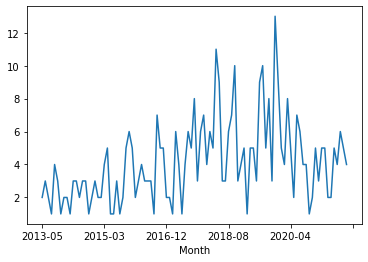

In [55]:
weapon = street[street["Crime type"] == "Possession of weapons"]
weapon.groupby(['Month'])['Crime type'].count().plot()

<AxesSubplot:xlabel='Month'>

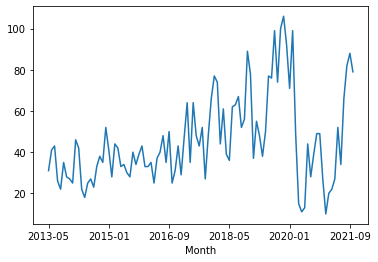

In [56]:
weapon = street[street["Crime type"] == "Theft from the person"]
weapon.groupby(['Month'])['Crime type'].count().plot()

<AxesSubplot:xlabel='Month'>

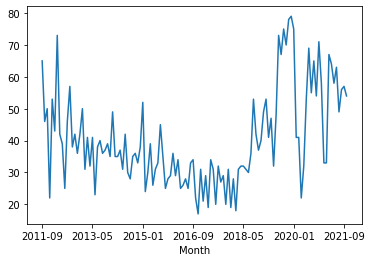

In [57]:
drugs = street[street["Crime type"] == "Drugs"]
drugs.groupby(['Month'])['Crime type'].count().plot()

<AxesSubplot:xlabel='Month'>

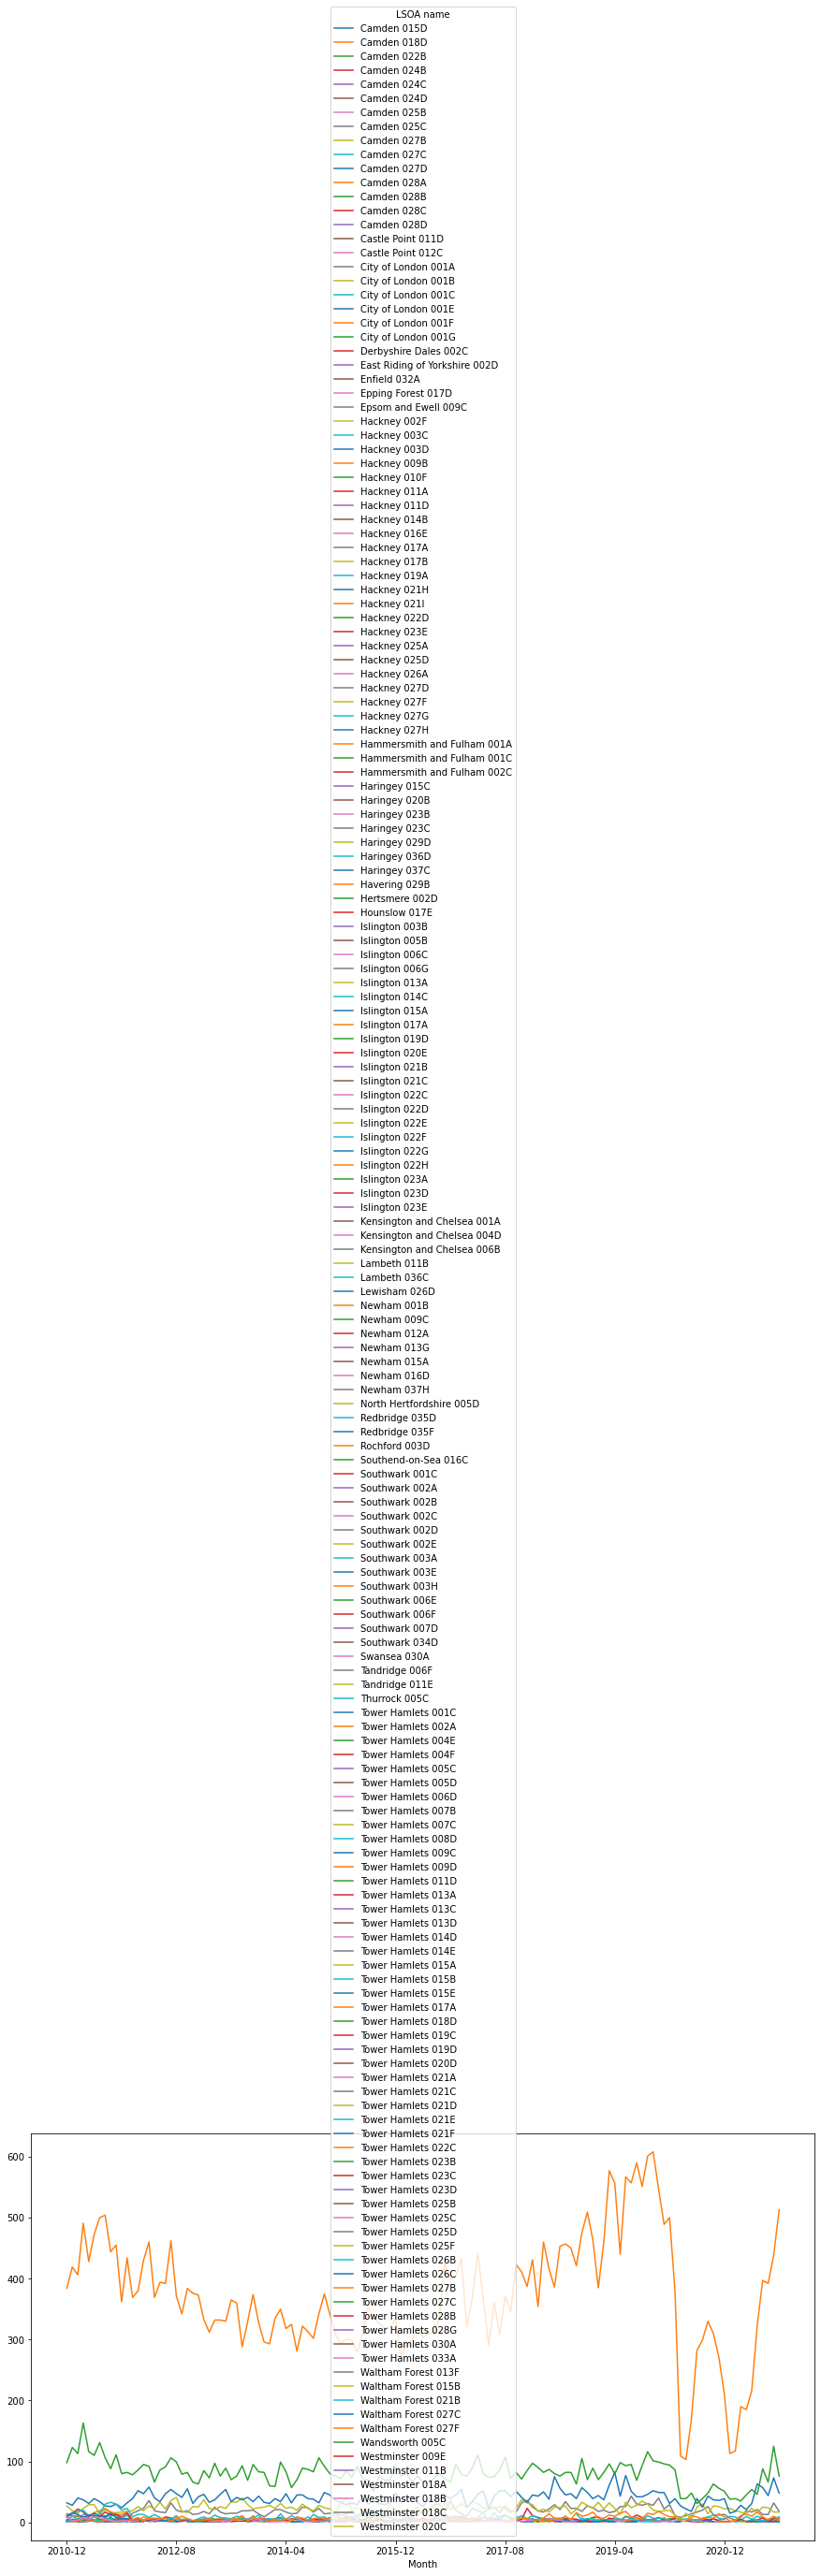

In [58]:
street.groupby(['Month', 'LSOA name'])['LSOA code'].count().unstack().plot(figsize = (15,8))  

<AxesSubplot:xlabel='Crime type'>

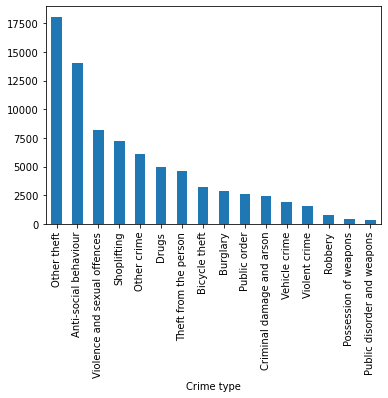

In [59]:
arrests = pd.Series(street.groupby("Crime type")["Crime type"].count().sort_values(ascending=False))
arrests.plot.bar()

<AxesSubplot:xlabel='LSOA name'>

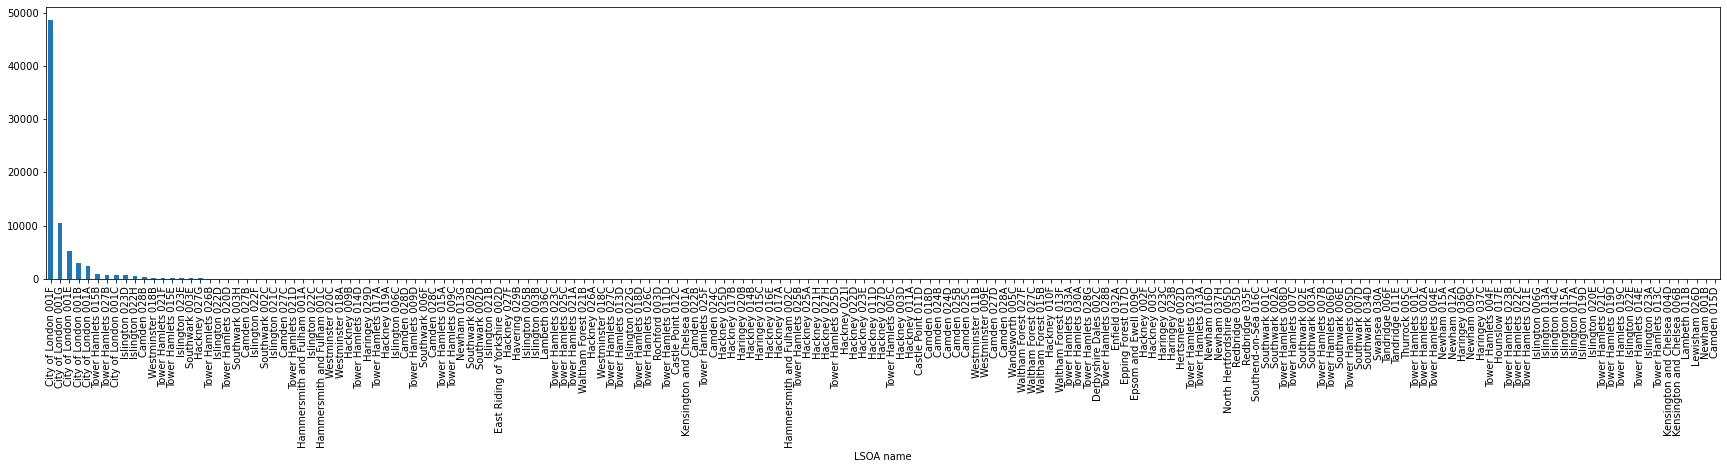

In [60]:
lsoa = pd.Series(street.groupby("LSOA name")["LSOA name"].count().sort_values(ascending=False))
lsoa.plot.bar(figsize = (30, 5))

<AxesSubplot:xlabel='Outcome type'>

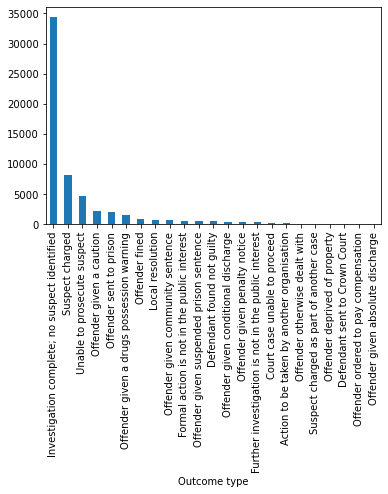

In [61]:
verdicts =pd.Series(outcomes.groupby("Outcome type")["Outcome type"].count().sort_values(ascending=False))
verdicts.plot.bar()

<AxesSubplot:xlabel='Outcome'>

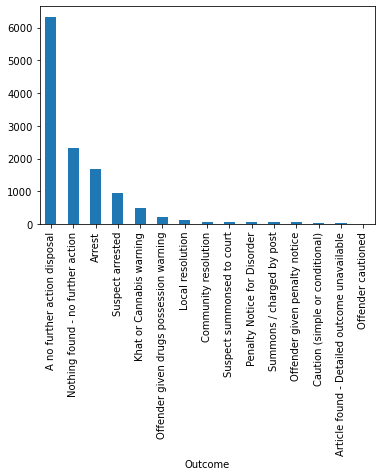

In [62]:
outcomessas = pd.Series(sas.groupby("Outcome")["Outcome"].count().sort_values(ascending=False))
outcomessas.plot.bar()

### Time series

In [63]:
forces = ['metropolitan', 'city-of-london', 'kent', 'sussex', 'surrey', 
          'essex', 'hertfordshire', 'thames-valley', 'bedfordshire', 'hampshire']
df_streets = load_forces(forces)

In [71]:
df_streets_all = pd.DataFrame()

for key in forces:
    df_streets_all = pd.concat([df_streets_all, df_streets[0][key]], ignore_index=True)

In [72]:
df_streets_all.dtypes

Unnamed: 0                 int64
Crime ID                  object
Month                     object
Reported by               object
Falls within              object
Longitude                float64
Latitude                 float64
Location                  object
LSOA code                 object
LSOA name                 object
Crime type                object
Last outcome category     object
Context                   object
dtype: object

In [73]:
file_path_employment = './Data/2019_employment.csv'
df_employment = pd.read_csv(file_path_employment, low_memory=False, sep=';')

In [74]:
df_employment.dtypes

LSOA Code (2011)                                     object
LSOA name (2011)                                     object
Local Authority District code (2019)                 object
Local Authority District name (2019)                 object
Employment Domain Score                              object
Employment Domain Rank (where 1 is most deprived)     int64
dtype: object

In [75]:
df_employment[df_employment['LSOA Code (2011)'] == 'E01000027']

,LSOA Code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Employment Domain Score,Employment Domain Rank (where 1 is most deprived)
24,E01000027,Barking and Dagenham 001A,E09000002,Barking and Dagenham,"0,146",7735


In [76]:
df_employment.columns

Index(['LSOA Code (2011)', 'LSOA name (2011)',
       'Local Authority District code (2019)',
       'Local Authority District name (2019)', 'Employment Domain Score',
       'Employment Domain Rank (where 1 is most deprived)'],
      dtype='object')

In [77]:
df_employment[['LSOA Code (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Employment Domain Score']]
        

,LSOA Code (2011),Local Authority District code (2019),Local Authority District name (2019),Employment Domain Score
0,E01000001,E09000001,City of London,"0,010"
1,E01000002,E09000001,City of London,"0,027"
2,E01000003,E09000001,City of London,"0,086"
3,E01000005,E09000001,City of London,"0,136"
4,E01000006,E09000002,Barking and Dagenham,"0,059"
...,...,...,...,...
34748,W01001954,W06000015,Cardiff,"0,079"
34749,W01001955,W06000011,Swansea,"0,366"
34750,W01001956,W06000011,Swansea,"0,028"
34751,W01001957,W06000011,Swansea,"0,149"


In [78]:
df_streets_all = df_streets_all.merge(df_employment[['LSOA Code (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Employment Domain Score']]
        , how = 'left', left_on = 'LSOA code', right_on = 'LSOA Code (2011)')

In [79]:
df_streets_all = df_streets_all.drop(['LSOA Code (2011)'], axis=1)

In [80]:
file_path_income = './Data/2019_income.csv'
df_income = pd.read_csv(file_path_income, low_memory=False, sep=';')

In [81]:
df_income.dtypes

LSOA Code (2011)                                  object
LSOA name (2011)                                  object
Local Authority District code (2019)              object
Local Authority District name (2019)              object
Income Domain Score                               object
Income Domain Rank (where 1 is most deprived)      int64
IDACI Score                                       object
IDACI Rank (where 1 is most deprived)              int64
IDAOPI Score                                      object
IDAOPI Rank (where 1 is most deprived)             int64
Unnamed: 10                                      float64
Unnamed: 11                                      float64
Unnamed: 12                                      float64
Unnamed: 13                                      float64
Unnamed: 14                                      float64
Unnamed: 15                                      float64
dtype: object

In [82]:
df_income[df_income['LSOA Code (2011)'] == 'E01000027']

,LSOA Code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Income Domain Score,Income Domain Rank (where 1 is most deprived),IDACI Score,IDACI Rank (where 1 is most deprived),IDAOPI Score,IDAOPI Rank (where 1 is most deprived),Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
24,E01000027,Barking and Dagenham 001A,E09000002,Barking and Dagenham,"0,216",6216,"0,276",6009,"0,231",8506,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
df_income.columns

Index(['LSOA Code (2011)', 'LSOA name (2011)',
       'Local Authority District code (2019)',
       'Local Authority District name (2019)', 'Income Domain Score',
       'Income Domain Rank (where 1 is most deprived)', 'IDACI Score',
       'IDACI Rank (where 1 is most deprived)', 'IDAOPI Score',
       'IDAOPI Rank (where 1 is most deprived)', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')

In [84]:
df_income[['LSOA Code (2011)', 'Income Domain Score', 'IDACI Score', 'IDAOPI Score']]

,LSOA Code (2011),Income Domain Score,IDACI Score,IDAOPI Score
0,E01000001,"0,007","0,006","0,012"
1,E01000002,"0,034","0,037","0,030"
2,E01000003,"0,086","0,052","0,128"
3,E01000005,"0,211","0,209","0,322"
4,E01000006,"0,117","0,155","0,162"
...,...,...,...,...
34748,W01001954,"0,049","0,028","0,051"
34749,W01001955,"0,420","0,213","0,659"
34750,W01001956,"0,038","0,063","0,094"
34751,W01001957,"0,234","0,320","0,363"


In [85]:
df_streets_all = df_streets_all.merge(df_income[['LSOA Code (2011)', 'Income Domain Score', 'IDACI Score', 'IDAOPI Score']], how = 'left', left_on = 'LSOA code', right_on = 'LSOA Code (2011)')

In [86]:
df_streets_all = df_streets_all.drop(['LSOA Code (2011)'], axis=1)

In [87]:
df_streets_all.head()

,Unnamed: 0,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Local Authority District code (2019),Local Authority District name (2019),Employment Domain Score,Income Domain Score,IDACI Score,IDAOPI Score
0,0,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.145949,51.593914,On or near Providence Place,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
1,1,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140192,51.582311,On or near Hatch Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
2,2,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
3,3,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
4,4,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"


In [88]:
file_path_police_strength = './Data/police_strength.csv'
df_police_strength = pd.read_csv(file_path_police_strength, low_memory=False, sep=';')

In [89]:
df_police_strength.head()

,country,force_name,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,England,Avon & Somerset,"3,160","3,417","3,398","3,439","3,430","3,407","3,355","3,302","3,21","3,211","2,873","2,8","2,707","2,692","2,667","2,597","2,676","2,803"
1,England,Bedfordshire,"1,119","1,199","1,232","1,225","1,204","1,207","1,244","1,246","1,214","1,157","1,092","1,019","1,073","1,083","1,119","1,130","1,164","1,262"
2,England,Cambridgeshire,"1,391","1,412","1,418","1,449","1,402","1,379","1,45","1,471","1,398","1,377","1,384","1,37","1,362","1,349","1,346","1,383","1,447","1,545"
3,England,Cheshire,"2,137","2,204","2,207","2,218","2,235","2,181","2,18","2,155","2,079","2,011","2,013","1,925","1,952","2,011","2,008","2,020","2,006","2,088"
4,England,Cleveland,"1,592","1,697","1,689","1,702","1,739","1,692","1,756","1,724","1,655","1,529","1,463","1,382","1,326","1,259","1,283","1,257","1,198","1,325"


In [90]:
df_police_strength.dtypes

country       object
force_name    object
2003          object
2004          object
2005          object
2006          object
2007          object
2008          object
2009          object
2010          object
2011          object
2012          object
2013          object
2014          object
2015          object
2016          object
2017          object
2018          object
2019          object
2020          object
dtype: object

In [91]:
df_police_strength.columns

Index(['country', 'force_name', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020'],
      dtype='object')

In [92]:
df_police_strength[['force_name', '2019']]

,force_name,2019
0,Avon & Somerset,"2,676"
1,Bedfordshire,"1,164"
2,Cambridgeshire,"1,447"
3,Cheshire,"2,006"
4,Cleveland,"1,198"
5,Cumbria,"1,16"
6,Derbyshire,"1,767"
7,Devon & Cornwall,3
8,Dorset,"1,223"
9,Durham,"1,118"


In [93]:
df_streets_all['Reported by'].unique()

array(['Metropolitan Police Service', 'City of London Police',
       'Kent Police', 'Hampshire Constabulary',
       'Avon and Somerset Constabulary', 'Sussex Police', 'Surrey Police',
       'Essex Police', 'Hertfordshire Constabulary',
       'Thames Valley Police', 'Bedfordshire Police'], dtype=object)

In [94]:
force_conv = {'Metropolitan Police':'Metropolitan Police Service', 
              'London, City of':'City of London Police',
              'Kent':'Kent Police', 
              'Hampshire':'Hampshire Constabulary',
              'Avon & Somerset':'Avon and Somerset Constabulary', 
              'Sussex':'Sussex Police', 
              'Surrey':'Surrey Police',
              'Essex':'Essex Police',
              'Hertfordshire':'Hertfordshire Constabulary',
              'Thames Valley':'Thames Valley Police',
              'Bedfordshire':'Bedfordshire Police'}

In [95]:
df_police_strength['force_name'] = df_police_strength['force_name'].map(force_conv, na_action='ignore')

In [96]:
df_police_strength[df_police_strength['force_name'] == 'Bedfordshire Police']['2003']

1    1,119
Name: 2003, dtype: object

In [97]:
df_streets_all.head()

,Unnamed: 0,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Local Authority District code (2019),Local Authority District name (2019),Employment Domain Score,Income Domain Score,IDACI Score,IDAOPI Score
0,0,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.145949,51.593914,On or near Providence Place,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
1,1,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140192,51.582311,On or near Hatch Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
2,2,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
3,3,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"
4,4,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134947,51.588063,On or near Mead Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,E09000002,Barking and Dagenham,"0,146","0,216","0,276","0,231"


In [ ]:
for col in df_police_strength.columns[2:]:
    df_streets_all = df_streets_all.merge(df_police_strength[['force_name', col]], how = 'left', left_on = 'Reported by', right_on = 'force_name')
    df_streets_all = df_streets_all.drop(['force_name'], axis=1)

    

In [ ]:
df_streets_all = df_streets_all.merge(df_police_strength[['force_name', '2019']], how = 'left', left_on = 'Reported by', right_on = 'force_name')


In [ ]:
df_streets_all = df_streets_all.drop(['force_name'], axis=1)


In [ ]:
file_path_police_funding = './Data/police_funding.csv'
df_police_funding = pd.read_csv(file_path_police_funding, low_memory=False, sep=';')

In [ ]:
df_police_funding

In [ ]:
df_police_funding['Police force'] = df_police_funding['Police force'].map(force_conv, na_action='ignore')

In [ ]:
df_streets_all = df_streets_all.merge(df_police_funding[['Police force', '2018-19']], how = 'left', left_on = 'Reported by', right_on = 'Police force')


In [ ]:
df_streets_all.head(5)

In [ ]:
df_streets_all = df_streets_all.drop(['Police force'], axis=1)


In [ ]:
file_path_population = './Data/2018_population_data.csv'
df_population = pd.read_csv(file_path_population, low_memory=False, sep=';')

In [ ]:
df_population

In [ ]:
df_streets_all = df_streets_all.merge(df_population[['CODE', 'POPULATION (2018)']], how = 'left', left_on = 'Local Authority District code (2019)', right_on = 'CODE')


In [ ]:
df_streets_all.head()

In [ ]:
df_streets_all = df_streets_all.drop(['CODE'], axis=1)


In [ ]:
df_streets_all.rename(columns = {'2019':'Police Strength', '2018-19':'Police Funding', 'POPULATION (2018)':'Population'}, inplace = True)


In [ ]:
df_2019 = df_streets_all[df_streets_all['Month'].str.contains('2019')]

In [ ]:
df_2019.to_csv('./Data/2019_data.csv', index=False)

### Choropleth map

In [99]:
mapbox_access_token = 'pk.eyJ1Ijoia2Npbm5heSIsImEiOiJja3lkMDJhcmUwODJmMm9zMjhob2V1N296In0.ymuiGnyaAIJSFC71UwlZYQ'
px.set_mapbox_access_token(mapbox_access_token)

In [100]:
# Load different datasets
df_postcodes = pd.read_csv('./Data/2019_postcodes.csv', low_memory=False)
df_postcodes = df_postcodes[df_postcodes['rgn'] == 'E12000007']

LSOAS_all_of_london = list(df_postcodes['lsoa11'].unique())

df_income = pd.read_csv('./Data/2019_income.csv', low_memory=False)
df_income = df_income[df_income["LSOA Code (2011)"].isin(LSOAS_all_of_london)]

df_employment = pd.read_csv('./Data/2019_employment.csv', low_memory=False)
df_employment = df_employment[df_employment["LSOA Code (2011)"].isin(LSOAS_all_of_london)]

df_stop_and_search = pd.read_csv('./Data/2019_city_of_london_stop_and_search.csv').append(pd.read_csv('./Data/2019_metropolitan_stop_and_search.csv'))
df_arrests = df_stop_and_search[df_stop_and_search['Outcome linked to object of search'] == True]

df_searches = df_stop_and_search[df_stop_and_search['Latitude'].notnull()]
df_searches = df_searches[df_searches['Longitude'].notnull()]

df_arrests = df_arrests[df_arrests['Latitude'].notnull()]
df_arrests = df_arrests[df_arrests['Longitude'].notnull()]

ParserError: Error tokenizing data. C error: Expected 4 fields in line 12365, saw 5


In [ ]:
df_metropolitan_street = combine_csvs_in_dir_to_df('multidata/metropolitan/street')
df_metropolitan_street = df_metropolitan_street[df_metropolitan_street["LSOA code"].isin(LSOAS_all_of_london)]

df_cityoflondon_street = combine_csvs_in_dir_to_df('multidata/city-of-london/street')
df_cityoflondon_street = df_cityoflondon_street[df_cityoflondon_street["LSOA code"].isin(LSOAS_all_of_london)]

df_alloflondon_street = df_metropolitan_street.append(df_cityoflondon_street)
df_alloflondon_street = df_alloflondon_street.dropna(axis=0, subset=['Crime type'])

In [ ]:
# Group the data
df_alloflondon_street_counts = df_alloflondon_street.groupby('LSOA code').size().to_frame('size')
df_alloflondon_street_counts.reset_index(level=0, inplace=True)
df_alloflondon_street_counts['log(size)'] = df_alloflondon_street_counts['size'].apply(lambda x: math.log(x))
df_alloflondon_street_counts = df_alloflondon_street_counts.rename(columns={"size": "Crime rate", "log(size)": "Crime rate log"})
df_alloflondon_street_counts.head(5)

In [ ]:
# Load GeoJSON file
GEOJSON_FULL = json.load(open('Data\LSOAS_all_of_london.geojson'))

In [ ]:
# Create Mapbox choropleth map

In [ ]:
fig = px.choropleth_mapbox(
    df_income,
    geojson = GEOJSON_FULL,
    locations = 'LSOA Code (2011)',
    color = 'Income Domain Rank (where 1 is most deprived)',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

In [ ]:
fig = px.choropleth_mapbox(
    df_employment,
    geojson = GEOJSON_FULL,
    locations = 'LSOA Code (2011)',
    color = 'Employment Domain Rank (where 1 is most deprived)',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

In [ ]:
fig = go.Figure(go.Scattermapbox(
        lat=list(df_searches['Latitude']),
        lon=list(df_searches['Longitude']),
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=2,
            opacity=1,
            color="orange"
        ),
        text=list(df_searches['Type']),
        name="Searches"
    ))

fig.add_trace(
    go.Scattermapbox(
        lat=list(df_arrests['Latitude']),
        lon=list(df_arrests['Longitude']),
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            opacity=1,
            color="blue"
        ),
        text=list(df_arrests['Type']),
        name="Arrests"
    )
)

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=51.49,
            lon=-0.12
        ),
        pitch=0,
        zoom=8.6
    )
)

fig.show()

In [ ]:
fig = px.choropleth_mapbox(
    df_alloflondon_street_counts,
    geojson = GEOJSON_FULL,
    locations = 'LSOA code',
    color = 'Crime rate',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

In [ ]:
fig = px.choropleth_mapbox(
    df_alloflondon_street_counts,
    geojson = GEOJSON_FULL,
    locations = 'LSOA code',
    color = 'Crime rate log',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

## Models

### K-Nearest Neighbors

In [ ]:
data =  pd.read_csv('.Data/2019_data.csv', encoding='utf-8', decimal=',')
data.shape
prob = data

In [ ]:
#to give insight in the crimes per LSOA in 2019
crimerate = prob.groupby('LSOA code')['Month'].count()
#sum(crimerate.values)
crimerate

In [ ]:
#to get the cluster data for each lsoa once
prob = prob.drop_duplicates(subset="LSOA code", keep='first')

In [ ]:
#remove the nan values
a = prob[prob['Employment Domain Score'].notna()]

In [ ]:
### Get all the features columns except the class
features_lst = ['LSOA code','Employment Domain Score','Income Domain Score','IDACI Score','IDAOPI Score','Police Strength',
                'Police Funding','Population']


### Get the features data
data = a[features_lst].reset_index()

In [ ]:
fit_data = data[['Employment Domain Score', 'Income Domain Score',
       'IDACI Score', 'IDAOPI Score', 'Police Strength', 'Police Funding',
       'Population']]

In [ ]:
#remove the 1.101.360 -> this is not computable to float
fit_data['Population'] = fit_data['Population'].replace(['1.101.360'],'1101.360')

In [ ]:
#replace the nan values with the mode of the column
for column in fit_data.columns:
    fit_data[column].fillna(fit_data[column].mode()[0], inplace=True)

In [ ]:
fit_data

In [ ]:
clf = KMeansConstrained(n_clusters = 50, size_min=250, size_max=800,random_state=0)

In [ ]:
clf.fit(fit_data)

In [ ]:
#make a new dataframe
label_data = pd.DataFrame({'LSOA code': data['LSOA code'], 'Cluster': clf.labels_})
#label_data

In [ ]:
label_data.sort_values(by=['LSOA code'], inplace = True)
label_data['crime numb'] = crimerate.values
label_data.groupby('Cluster')['crime numb'].sum().plot(kind ='bar', ylabel='Number of crimes', 
                                                       title=' Distribution of crimes over the clusters');

In [ ]:
label_data.groupby('Cluster')

In [ ]:
#makes a dataframe for each cluster
df = [x for _, x in label_data.groupby('Cluster')]
numbcrimes = []
for i in df:
    numbcrimes.append(i['crime numb'].sum())

In [ ]:
plt.hist(numbcrimes, bins=23)

In [ ]:
cluster1 = df[2]['LSOA code'].values.tolist()
#cluster1

In [ ]:
df_street = pd.read_csv('./Data/city-of-london/city-of-london_street.csv')
df_street.index = pd.to_datetime(df_street['Month'])
df_notna = df_street[df_street['LSOA code'].notna()]

In [ ]:
df_notna = df_notna[df_notna['LSOA code'].isin(cluster1)]

In [ ]:
data = df_notna.groupby(by=[df_notna.index.date])['Month'].count()
data

### SARIMA

In [ ]:
# split the data into train and testdata and remove the covid data
for t in range(0,len(data.index)):
    if data.index[t] >= datetime.date(2019, 1, 1):
        break
for m in range(t+1, len(data.index)):
    if data.index[m] >= datetime.date(2020,1,1):
        break

data_train = data[:t]
data_test = data[t:m]

In [ ]:
#plot the train test split
sns.lineplot(data=data_train)
sns.lineplot(data=data_test);

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
Sarima = pm.auto_arima(data_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Sarima.summary() 

In [ ]:
n_periods = 12
fitted, confint = Sarima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data_train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data_train)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA model for LSOA E01000001")
plt.plot(data_test)
plt.legend()
plt.show()

### Decision Tree Model

In [ ]:
# Input the 2019 Dataset
df = pd.read_csv('./Data/2019_data.csv')

In [ ]:
# Display import
df.head(-5)

In [ ]:
# Drop required values that contain NAN
df.dropna(subset=['LSOA code', 'Month', 'Location', 'Crime type', 'Longitude', 'Latitude', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population'], inplace=True)

In [ ]:
df[df['Month'] == '2019-05']['Crime type'].mode()

In [ ]:
for month in df['Month'].unique():
    print(month)
    print(df[df['Month'] == month]['Crime type'].mode())

In [ ]:
df.columns

In [ ]:
df.replace(to_replace=",", value=".", regex=True, inplace=True)

In [ ]:
df['Population'].isnull().sum()

In [ ]:
df['Police Strength'].isnull().sum()

In [ ]:
df['Population'] = df['Population'].str.replace('.', '').fillna(df['Population']*1000)

In [ ]:
df['Police Strength'] = df['Police Strength'].str.replace('.','')

#### Crime Type Prediction

In [ ]:
# Encode Desired Values to integers to use in models
ohe = LabelEncoder()
df['E LSOA code'] = ohe.fit_transform(df['LSOA code'].dropna().values)
df['E Month'] = ohe.fit_transform(df['Month'].dropna().values)
df['E Location'] = ohe.fit_transform(df['Location'].dropna().values)

In [ ]:
# Create an X and Y
X = df[['E LSOA code', 'E Month', 'E Location', 'Longitude', 'Latitude', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population']].values
Y = df['Crime type'].values

In [ ]:
# Fit Decision Tree on Crime Types and split the dataset in training and data.
clf = tree.DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
# Predictions on Test Set
preds = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

In [ ]:
# Predictions in a Dataframe
df_preds = pd.DataFrame()
df_preds['y'] = y_test
df_preds['pred'] = preds

In [ ]:
df_preds

In [ ]:
# Accuracy
len(df_preds.loc[df_preds['y'] == df_preds['pred']]) / len(y_test)

In [ ]:
df_preds['y'].value_counts()

In [ ]:
df_preds['pred'].value_counts()

In [ ]:
balanced_accuracy_score(df_preds['y'].values, df_preds['pred'].values)

0.13067339856724494

In [ ]:
accuracies = {}
for crime in df_preds['y'].unique():
    crime_y = df_preds.loc[df_preds['y'] == crime, 'y'].values
    crime_pred = df_preds.loc[df_preds['y'] == crime, 'pred'].values
    acc = round(accuracy_score(crime_y,crime_pred) * 100,2)
    accuracies[crime] = acc
#     print('Accuracy for {} is {}%'.format(crime,acc))
df_crimes = pd.DataFrame.from_dict(accuracies, orient='index').sort_values(0, ascending=False)
df_crimes

,0
Violence and sexual offences,69.96
Anti-social behaviour,38.33
Shoplifting,33.17
Other theft,21.49
Theft from the person,13.91
Vehicle crime,2.73
Other crime,1.33
Drugs,0.69
Bicycle theft,0.56
Possession of weapons,0.50


In [ ]:
counts = {}
for crime in df_preds['y'].unique():
    c = round((len(df_preds[df_preds['y'] == crime]) / len(df_preds)) *100,2)
    counts[crime] = c
df_crimes['Relativity'] = df_crimes.index.map(counts)
df_crimes

,0,Relativity
Violence and sexual offences,69.96,26.47
Anti-social behaviour,38.33,19.16
Shoplifting,33.17,4.98
Other theft,21.49,9.40
Theft from the person,13.91,2.73
Vehicle crime,2.73,8.94
Other crime,1.33,1.41
Drugs,0.69,3.16
Bicycle theft,0.56,1.62
Possession of weapons,0.50,0.70


In [ ]:
#df_preds['y'].value_counts().plot(kind='barh')
x = [str(x) for x in df_preds['y'].value_counts().sort_index().index.values]
y = df_preds['y'].value_counts().sort_index().values
y2 = [len(df_preds[df_preds['pred'] == crime]) for crime in x]
len(x), len(y), len(y2)

(14, 14, 14)

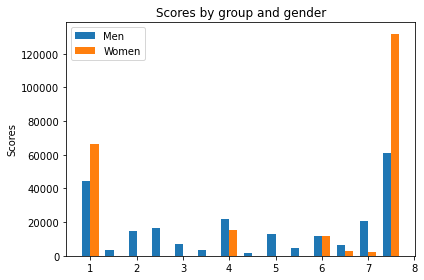

In [ ]:
labels = x
men_means = y
women_means = y2

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticklabels(x)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
# Plot the Decision Tree
tree.plot_tree(clf);

### Experimental

#### Random Forest

#### XG Boost